In [1]:
import numpyro
numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)

import arviz as az
import numpy as np
import pandas as pd
import jax.numpy as jnp
from cycler import cycler
import matplotlib
import matplotlib.pyplot as plt
from jax import random, jit, lax, pmap, vmap
from corner import corner, overplot_points, overplot_lines
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, init_to_uniform, init_to_feasible, Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoBNAFNormal, AutoIAFNormal, AutoMultivariateNormal
from numpyro.optim import Adam
from eggman.infer import Star
from functools import partial
from corner import corner

rng = random.PRNGKey(42)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
I0000 00:00:1699539903.251689   66185 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
import numpyro.distributions as dist

In [3]:
from jax.scipy import stats

In [4]:
def clamp_probs(probs):
    finfo = jnp.finfo(jnp.result_type(probs, float))
    return jnp.clip(probs, a_min=finfo.tiny, a_max=1.0 - finfo.eps)

def truncnorm_ppf(q, a, b, loc=0.0, scale=1.0):
    q, a, b = jnp.broadcast_arrays(q, a, b)
    sign = jnp.where(loc >= a, 1.0, -1.0)
    
    tail_prob_at_low = stats.norm.cdf(loc - sign * (loc - a), loc=loc, scale=scale)
    tail_prob_at_high = stats.norm.cdf(loc - sign * (loc - b), loc=loc, scale=scale)
    
    return (1 - sign) * loc + sign * stats.norm.ppf(
            clamp_probs((1 - q) * tail_prob_at_low + q * tail_prob_at_high),
            loc=loc,
            scale=scale
        )

def pareto_ppf(q, scale, alpha):
    return scale / jnp.power(1 - q, 1 / alpha)

In [5]:
import dynesty
import dynesty.plotting as dyplot
from dynesty import NestedSampler

In [6]:
from eggman.emulator import Emulator
from eggman.infer.models import lognorm_from_norm

In [7]:
emulator = Emulator()

In [8]:
def mvnorm_ppf(q, mean, cov):
    chol = jnp.linalg.cholesky(cov)
    n01 = stats.norm.ppf(q)
    return mean + jnp.squeeze(jnp.matmul(chol, n01[..., None]), -1)

In [243]:
loc = np.array([np.log(0.1), -0.2])
cov = np.array([[1.5**2, 1.2],
                [0.45 , 0.7**2]])

class NestedStar(Star):
    max_distance = 500.
    
    def __init__(self, mu, sigma, bands=None):
        super().__init__(bands=bands)
        # EEP, mass, Y, M_H, MLT, log_plx, Av
#         self.low = jnp.array([
#             0.0, jnp.log(0.7), 0.22, -0.9, 1.3, -3.0, 0.0
#         ])
#         self.high = jnp.array([
#             1.0, jnp.log(2.3), 0.32, 0.5, 2.7, 0.0, 1.0
#         ])
        self.low = jnp.array([
            0.0, 0.7, 0.22, -0.9, 1.3, -3.0, 0.0
        ])
        self.high = jnp.array([
            4.0, 2.3, 0.32, 0.5, 2.7, 0.0, 1.0
        ])
        self.scale = self.high - self.low
        self.mu = jnp.array(mu)
        self.sigma = jnp.array(sigma)

    def prior_transform(self, u):
        # TODO: add mass prior and other priors
        x = self.low[0] + self.scale[0] * u[0]
#         x = dist.Beta(2, 7).icdf(u[0])
        mass = self.low[1] + self.scale[1] * u[1]
#         ln_mass = truncnorm_ppf(u[1], self.low[1], self.high[1], -0.2, 0.7)
#         ln_x, ln_mass = mvnorm_ppf(u[:2], loc, cov)
        y = self.low[2] + self.scale[2] * u[2]
#         mh = truncnorm_ppf(u[3], self.low[3], self.high[3], self.mu[4], self.sigma[4])
        mh = self.low[3] + self.scale[3] * u[3]
        a_mlt = self.low[4] + self.scale[4] * u[4]
        ln_plx = stats.norm.ppf(u[5], *lognorm_from_norm(self.mu[5], self.sigma[5]))
        ln_av = stats.norm.ppf(u[6], *lognorm_from_norm(self.mu[6], self.sigma[6]))

#         return jnp.hstack([jnp.exp(ln_x), ln_mass, y, mh, a_mlt, ln_plx, ln_av])
        return jnp.hstack([x, mass, y, mh, a_mlt, ln_plx, ln_av])
    
    def log_likelihood(self, x):
        # eep = self.evol_phase(x[0])
        eep = x[0]
#         mass = jnp.exp(x[1])
        mass = x[1]
        
        log_z = jnp.log10(self.heavy_elements(x[2], x[3]))
        inputs = jnp.hstack([eep, mass, x[2], log_z, x[4]])
        outputs = emulator.model_jax(inputs)

        log_lum = self.log_luminosity(outputs[1], outputs[2])
        log_g = self.log_gravity(jnp.log10(x[1]), outputs[2])
        teff = 10**outputs[1]
        plx = jnp.exp(x[-2])
#         plx = 10**x[-2]
        av = jnp.exp(x[-1])
        inputs = jnp.hstack([teff, log_g, x[3], av])
#         print(inputs)
        bc = self.bc_interp(inputs).squeeze()
#         print(bc)
        bol_mag = self.bolometric_magnitude(log_lum)
        abs_mag = self.absolute_magnitude(bol_mag, bc)
        mag = self.apparent_magnitude(abs_mag, plx)
#         return *mag, x[3], plx, x[-1]

        log_like = stats.t.logpdf(mag, df=self.dof, loc=self.mu[:4], scale=self.sigma[:4]).sum()
        # TODO: Get rid of these and turn them into priors -> make priors flat in HBM
#         log_like += stats.norm.logpdf(x[3], loc=self.mu[4], scale=self.sigma[4])
#         log_like += stats.norm.logpdf(plx, loc=self.mu[5], scale=self.sigma[5])
#         log_like += stats.norm.logpdf(x[-1], loc=self.mu[6], scale=self.sigma[6])
        return log_like

Beta dist with beta = 1 is just a bounded power law dist where the power is (alpha - 1)

In [12]:
truths = pd.read_csv("truths.csv", index_col=0)
truths.head()

Av  Av_scaled         BP    BP_abs         Dnu       EEP          G  \
0  0.616694   0.616694  12.920905  4.434871   46.531516  2.972540  12.372801   
1  0.674316   0.674316  16.390991  8.036840  198.858381  0.254729  15.627133   
2  0.454503   0.454503  12.122991  5.034400   76.729583  2.151841  11.659842   
3  0.845769   0.845769  12.444456  4.691477   52.842872  2.600444  11.923063   
4  0.827635   0.827635  14.615854  6.176617   59.334573  3.112495  13.899241   

      G_abs          K     K_abs  ...   ln_mass    log_age   log_lum  \
0  3.886768  10.244147  1.758113  ...  0.202925   9.752194  0.530279   
1  7.272982  12.779389  4.425238  ... -0.237982   8.887089 -0.727580   
2  4.571252   9.760153  2.671563  ... -0.130896  10.221406  0.203113   
3  4.170084   9.827575  2.074597  ... -0.027377   9.941072  0.493744   
4  5.460005  11.142832  2.703596  ... -0.331714  10.645755  0.022774   

    log_rad      logg       lum      mass       plx       rad         x  
0  0.343407  3.841316  3.390619  1.224981  0.002008  2.204990  0.697254  
1 -0.145022  4.626691  0.187249  0.788217  0.002134  0.716107  0.076419  
2  0.150114  4.082924  1.596293  0.877309  0.003822  1.412909  0.615184  
3  0.273575  3.880960  3.117051  0.972994  0.002815  1.877480  0.660044  
4  0.192668  3.910603  1.053837  0.717693  0.002052  1.558359  0.733749  

[5 rows x 29 columns]

In [13]:
bands = ["G", "BP", "RP", "K"]

In [244]:
i = 0
mu = truths.loc[i, [*bands, "M_H", "plx", "Av"]].to_numpy()
sigma = [3e-3] * len(bands) + [0.1, 4e-5, 0.01*mu[-1]]
mu[4] = 0.0
sigma[4] = 0.7

model = NestedStar(mu, sigma, bands=bands)
model.dof = 10

In [245]:
rng, key = random.split(rng)
ndim = len(model.low)

u = random.uniform(key, shape=(20000, ndim))
prior_samples = vmap(model.prior_transform)(u)
# mask = (prior_samples[:, 0] > 0.001) & (prior_samples[:, 0] < 1) & (prior_samples[:, 1] > jnp.log(0.7)) & (prior_samples[:, 1] < jnp.log(2.3))
# prior_samples = prior_samples[mask]

In [249]:
def emulator_outputs(x):
    # eep = model.evol_phase(x[0])
    eep = x[0]

    log_z = jnp.log10(model.heavy_elements(x[2], x[3]))
    inputs = jnp.hstack([eep, *x[1:3], log_z, x[4]])
    return emulator.model_jax(inputs)

In [250]:
prior_predictive = vmap(emulator_outputs)(prior_samples)

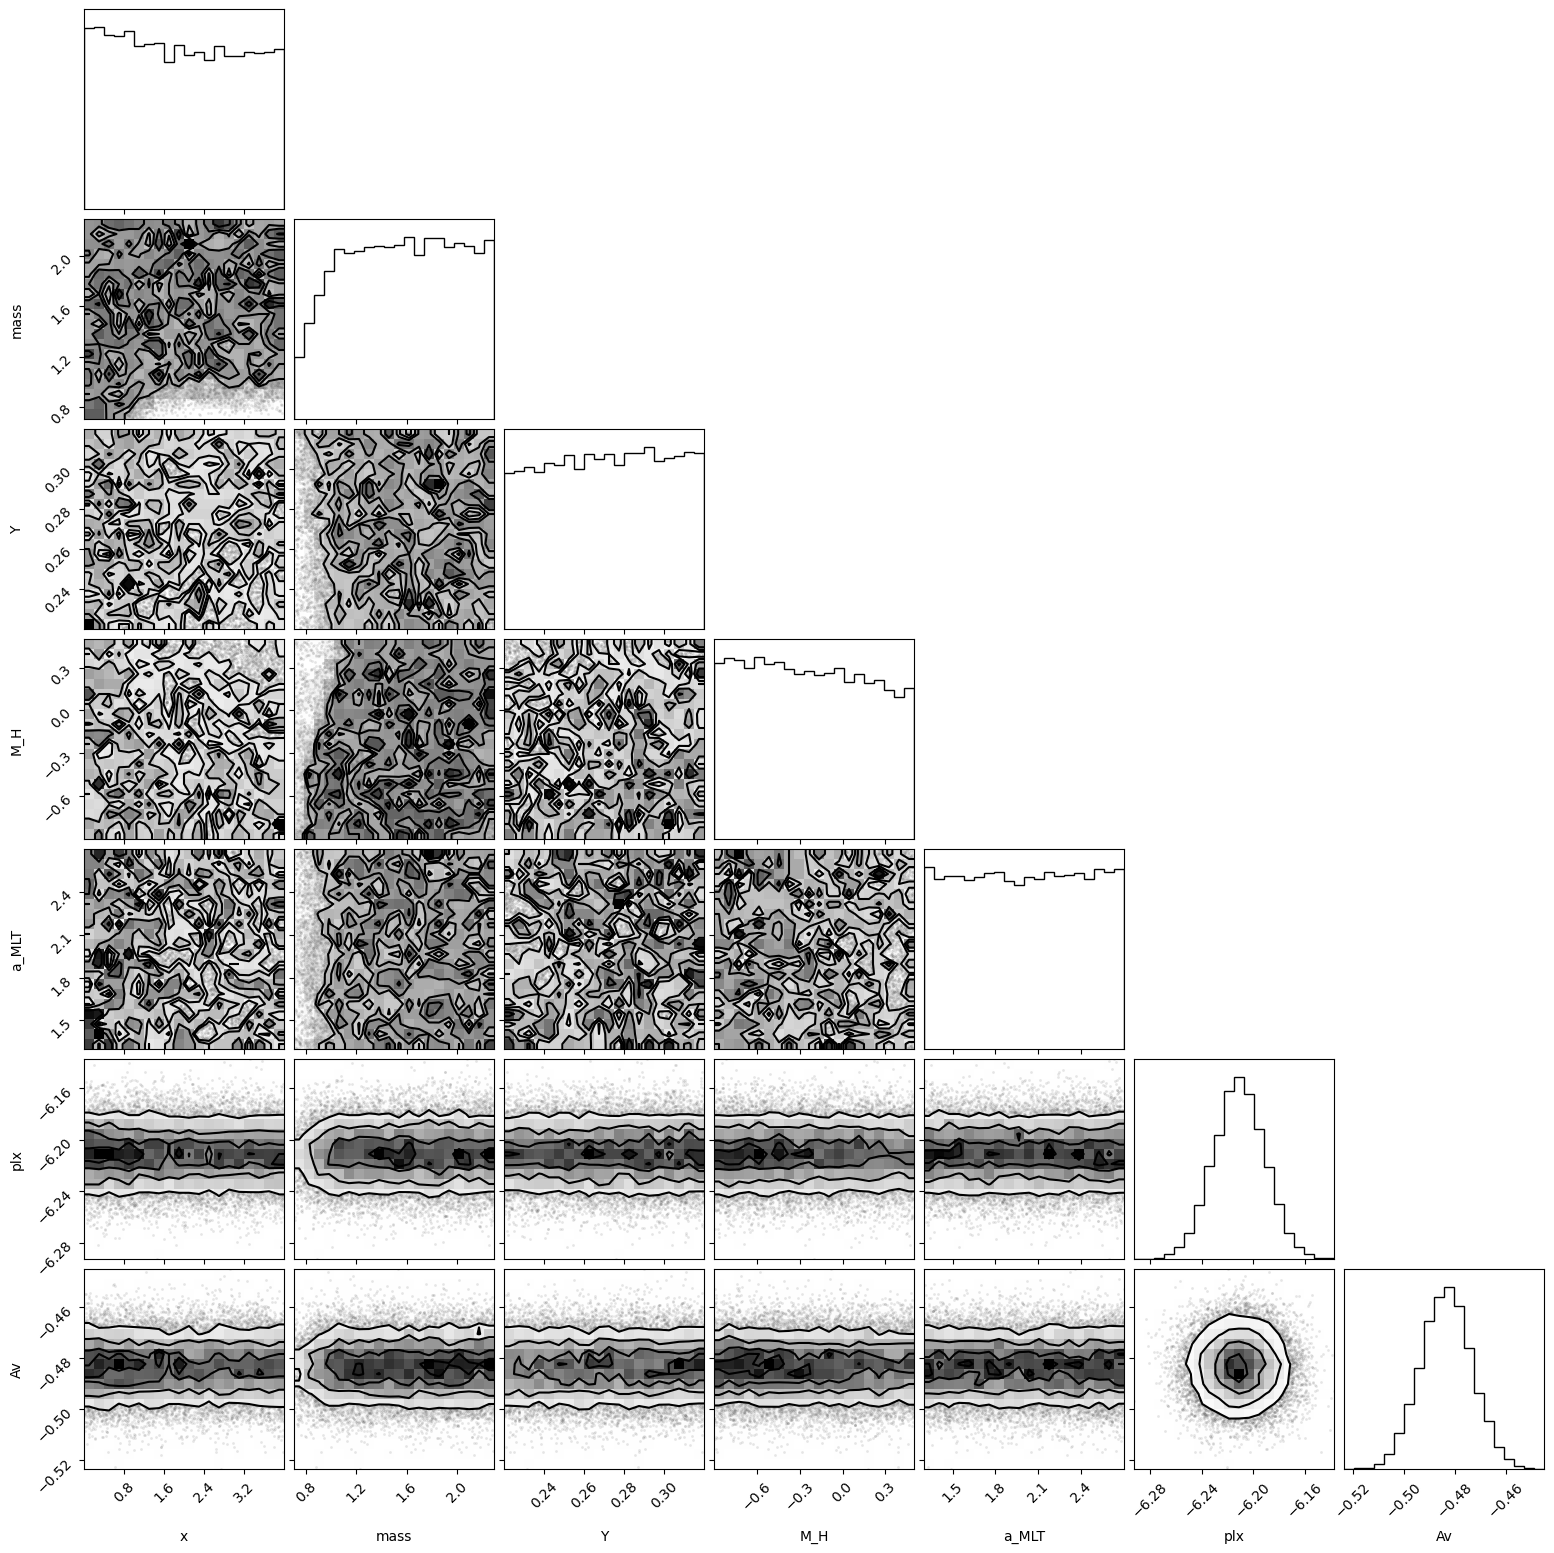

In [251]:
labels = ["x", "mass", "Y", "M_H", "a_MLT", "plx", "Av"]

xs = np.array(prior_samples)

mask = (prior_predictive[:, 0] < np.log10(14) + 9)
# mask = True
fig = corner(xs[mask], labels=labels)

In [252]:
labels = ["log_age", "log_Teff", "log_rad", "log_Dnu"]
xs = np.array(prior_predictive)
# mask = (prior_predictive[:, 0] < np.log10(14) + 9)
mask = True
xs[:, 0] = 10**xs[:, 0]
fig = corner(xs[mask], labels=labels)

In [253]:
log_age = np.array(prior_predictive[:, 0])
age = np.array(10**prior_predictive[:, 0])

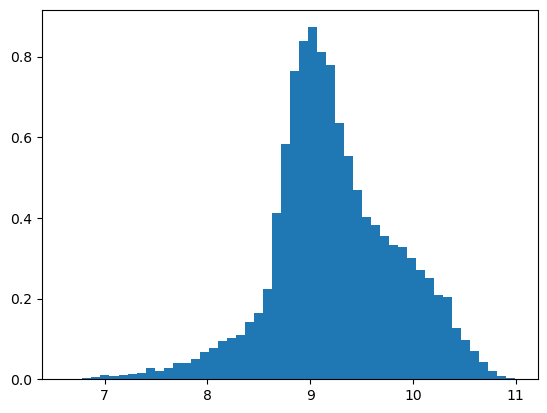

In [254]:
fig, ax = plt.subplots()
ax.hist(log_age, bins=50, density=True);

# fig, ax = plt.subplots()
# ax.hist(age, bins=50, density=True);

In [255]:
from scipy.stats import gaussian_kde

In [256]:
kernel = gaussian_kde(log_age)

In [257]:
p_est = kernel(log_age)

In [258]:
fig, ax = plt.subplots()
ax.hist(log_age, bins=50, density=True)
indices = np.argsort(log_age)
ax.plot(log_age[indices], p_est[indices]);

In [259]:
p = age/p_est
p *= age < 14e9
p /= p.sum()  # renormalise

In [260]:
rng, key = random.split(rng, 2)

# same key should give equiv results
resample_predictive = random.choice(key, prior_predictive, shape=(prior_predictive.shape[0],), p=p)
resample_prior = random.choice(key, prior_samples, shape=(prior_samples.shape[0],), p=p)

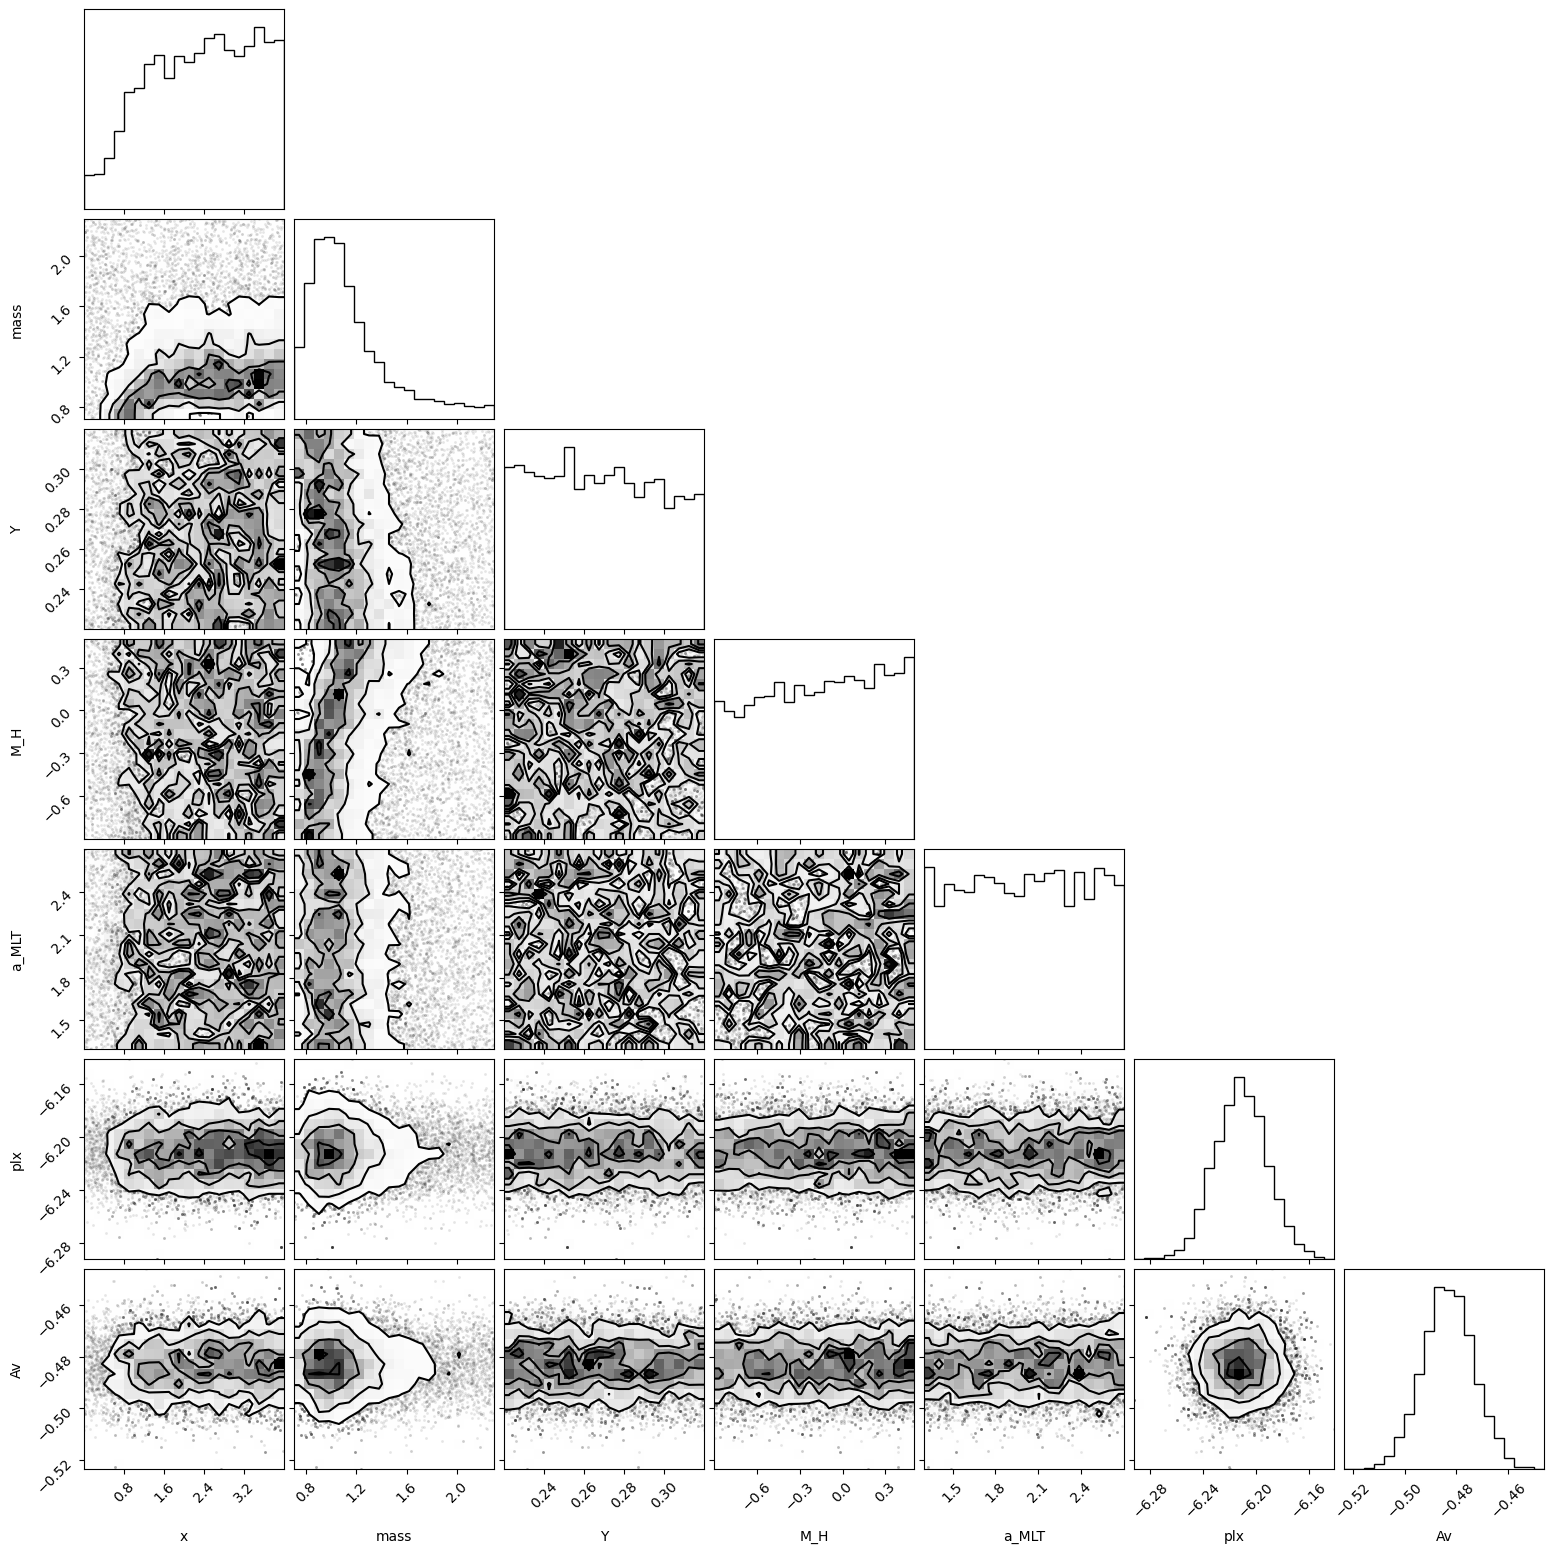

In [261]:
labels = ["x", "mass", "Y", "M_H", "a_MLT", "plx", "Av"]

xs = np.array(resample_prior)
# xs[:, 1] = np.exp(xs[:, 1])
fig = corner(xs, labels=labels)

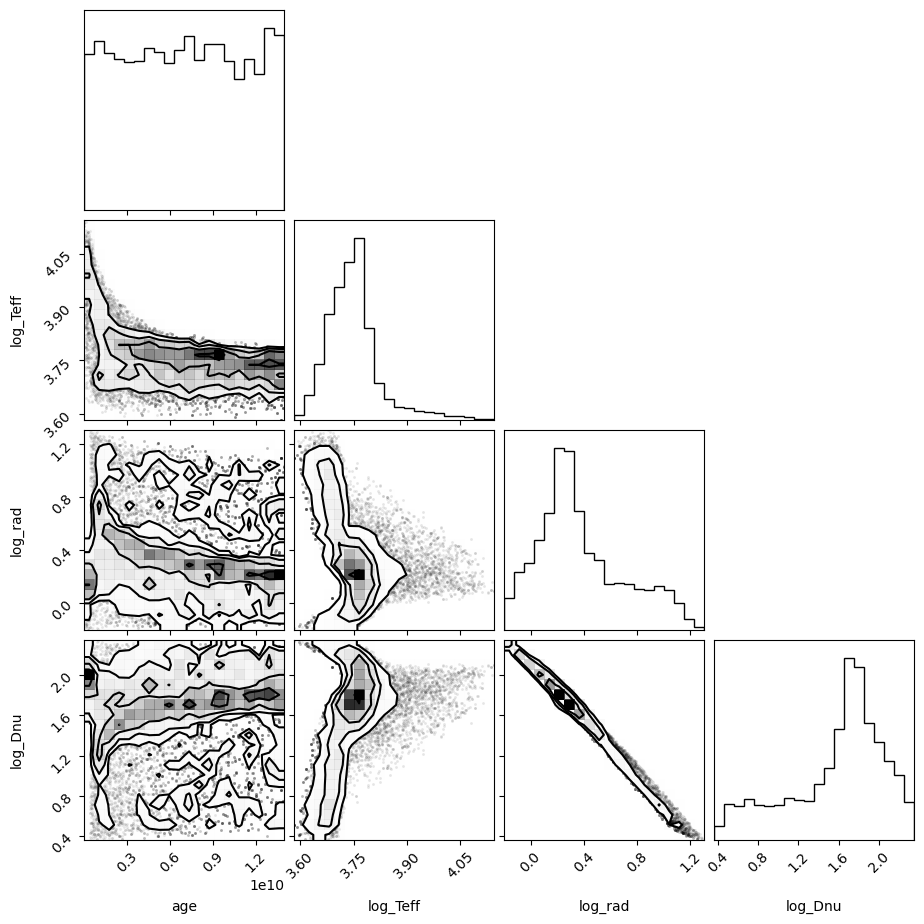

In [262]:
labels = ["age", "log_Teff", "log_rad", "log_Dnu"]
xs = np.array(resample_predictive)
# mask = (xs[:, 0] < np.log10(14) + 9) & (xs[:, 0] > 9)
xs[:, 0] = 10**xs[:, 0]
fig = corner(xs, labels=labels)

In [264]:
fig, ax = plt.subplots()

s = ax.scatter(prior_predictive[:, 1], prior_predictive[:, 2], c=prior_samples[:, 0], alpha=0.2)
ax.invert_xaxis()
fig.colorbar(s, label="x");

In [263]:
fig, ax = plt.subplots()

s = ax.scatter(resample_predictive[:, 1], resample_predictive[:, 2], c=resample_prior[:, 0], alpha=0.2)
ax.invert_xaxis()
fig.colorbar(s, label="x");

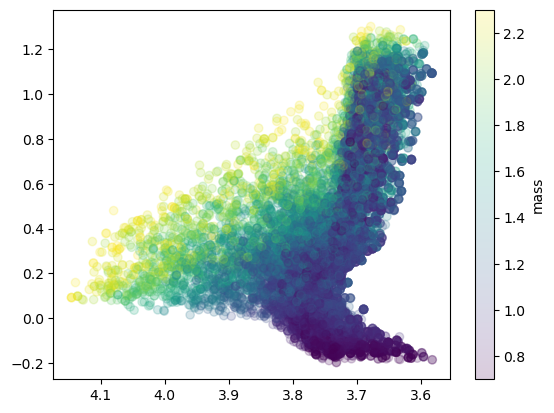

In [265]:
fig, ax = plt.subplots()

s = ax.scatter(resample_predictive[:, 1], resample_predictive[:, 2], c=resample_prior[:, 1], alpha=0.2)
ax.invert_xaxis()
fig.colorbar(s, label="mass");

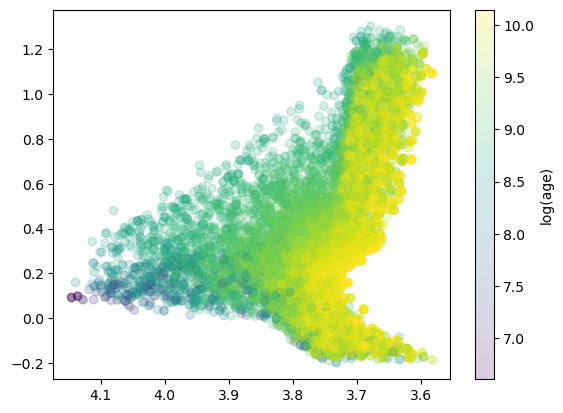

In [281]:
fig, ax = plt.subplots()

s = ax.scatter(resample_predictive[:, 1], resample_predictive[:, 2], c=resample_predictive[:, 0], alpha=0.2)
ax.invert_xaxis()
fig.colorbar(s, label="log(age)");

In [282]:
fig, ax = plt.subplots()

s = ax.scatter(resample_predictive[:, 1], resample_predictive[:, 2], c=resample_prior[:, 3], alpha=0.2)
ax.invert_xaxis()
fig.colorbar(s, label="[M/H]");

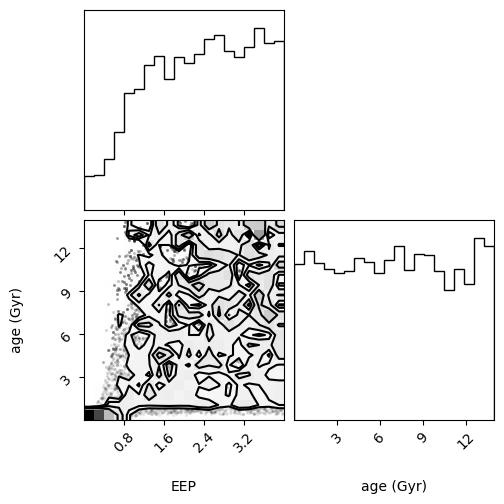

In [275]:
xs = np.stack([resample_prior[:, 0], 10**(resample_predictive[:, 0]-9)], -1)
fig = corner(xs, labels=["EEP", "age (Gyr)"])

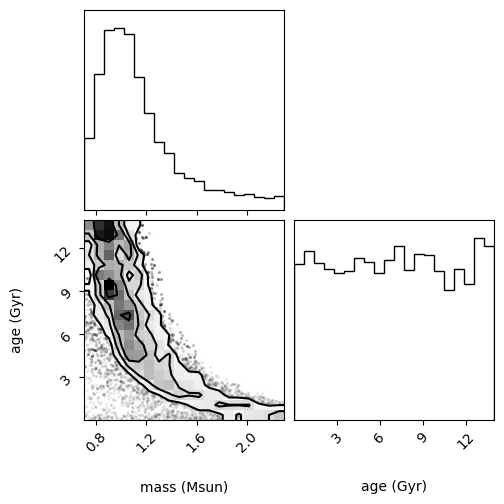

In [279]:
xs = np.stack([resample_prior[:, 1], 10**(resample_predictive[:, 0]-9)], -1)
fig = corner(xs, labels=["mass (Msun)", "age (Gyr)"])

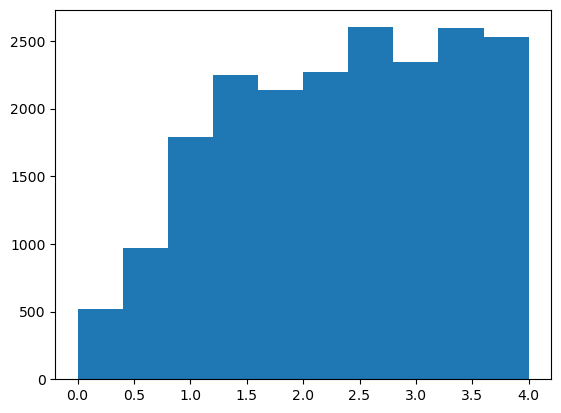

In [268]:
plt.hist(resample_prior[:, 0]);

In [297]:
values = np.stack([resample_predictive[:, 1], resample_predictive[:, 2]], -1)
kernel = gaussian_kde(values.T)

In [298]:
log_teff = np.linspace(resample_predictive[:, 1].min(), resample_predictive[:, 1].max(), 101)
log_rad = np.linspace(resample_predictive[:, 2].min(), resample_predictive[:, 2].max(), 101)
X, Y = np.meshgrid(log_teff, log_rad)
coords = np.vstack([X.ravel(), Y.ravel()])

In [301]:
# values = np.stack([prior_predictive[:, 1], prior_predictive[:, 2]], -1)
# kernel = gaussian_kde(values.T)

In [302]:
# log_teff = np.linspace(prior_predictive[:, 1].min(), prior_predictive[:, 1].max(), 101)
# log_rad = np.linspace(prior_predictive[:, 2].min(), prior_predictive[:, 2].max(), 101)
# X, Y = np.meshgrid(log_teff, log_rad)
# coords = np.vstack([X.ravel(), Y.ravel()])

In [299]:
Z = np.reshape(kernel(coords).T, X.shape)


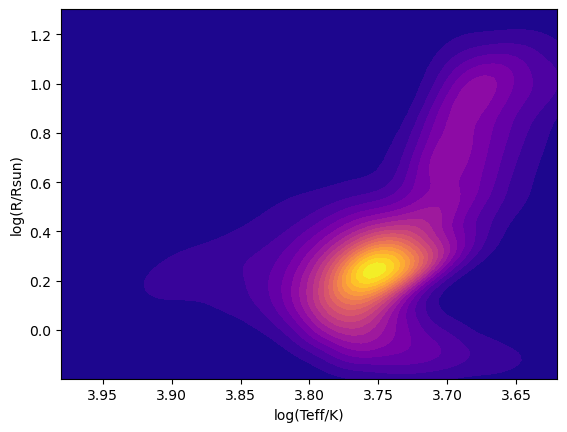

In [309]:
fig, ax = plt.subplots()
ax.contourf(X, Y, Z, levels=20, cmap="plasma")
ax.invert_xaxis()
ax.set_xlim(3.98, 3.62)
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(R/Rsun)");